In [1]:
from fastai.vision.all import *
import torchvision.models as models

In [53]:
models.resnet34(pretrained=True).children()

<generator object Module.children at 0x0000021DB7ABCD60>

In [61]:
class RaceModel(nn.Module):
    def __init__(self):
        super().__init__()
        layers = list(fastai.vision.models.resnet34.children())[:-2]
        layers += [AdaptiveConcatPool2d(), Flatten()]
        layers += [nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
        layers += [nn.Dropout(p=0.50)]
        layers += [nn.Linear(1024, 512, bias=True), nn.ReLU(inplace=True)]
        layers += [nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
        layers += [nn.Dropout(p=0.50)]
        layers += [nn.Linear(512, 16, bias=True), nn.ReLU(inplace=True)]
        layers += [nn.Linear(16,2)]
        self.racemodel = nn.Sequential(*layers)
    def forward(self, x):
        return self.racemodel(x).squeeze(-1)

In [3]:
models

<module 'torchvision.models' from 'D:\\Users\\Sander\\anaconda3\\envs\\AI\\lib\\site-packages\\torchvision\\models\\__init__.py'>

In [4]:
import os

In [5]:
images = [ f"./data/images/{x}" for x in os.listdir("./data/images")]

In [6]:
images[0]

'./data/images/100_image.png'

In [7]:
len(images)

203

In [8]:
images[202]

'./data/images/9_image.png'

In [9]:
import pandas as pd

In [10]:
df_data = pd.read_csv('./data/inputs.csv',names=["img_path", "X", "Y", "Throttle", "Brake"])

In [11]:
df_data.head()

,img_path,X,Y,Throttle,Brake
0,0_image.png,None,-2048,2,0
1,1_image.png,None,-2049,3,0
2,2_image.png,None,-2049,3,0
3,3_image.png,None,-2049,3,0
4,4_image.png,None,-2049,3,0


In [12]:
df_data.tail()

,img_path,X,Y,Throttle,Brake
235,235_image.png,0,-2560,0,0
236,236_image.png,-2049,-2048,0,0
237,237_image.png,-12289,-1025,0,0
238,238_image.png,0,-513,0,0
239,239_image.png,None,-1024,0,0


In [13]:
del df_data["Y"]

In [14]:
df_data.head()

,img_path,X,Throttle,Brake
0,0_image.png,None,2,0
1,1_image.png,None,3,0
2,2_image.png,None,3,0
3,3_image.png,None,3,0
4,4_image.png,None,3,0


In [15]:
df_data["X"] = df_data["X"].transform(lambda x: '0' if x == "None" else x)

In [16]:
df_data["X"] = df_data["X"].astype(int) 

In [17]:
def transformX(x):
    #output: 0 to 32767
    #input: -32767 to 32767
    X = int(x)
    return int(X + 32767 / 2)

In [18]:
df_data["X"] = df_data["X"].transform(transformX)

In [19]:
df_data.head()

,img_path,X,Throttle,Brake
0,0_image.png,16383,2,0
1,1_image.png,16383,3,0
2,2_image.png,16383,3,0
3,3_image.png,16383,3,0
4,4_image.png,16383,3,0


In [20]:
df_data["Throttle"] = df_data["Throttle"].astype(int) 
df_data["Brake"] = df_data["Brake"].astype(int) 

In [21]:
df_data["Throttle"] = df_data["Throttle"] / 254 * 32767 * -1

In [22]:
df_data.head()

,img_path,X,Throttle,Brake
0,0_image.png,16383,-258.007874,0
1,1_image.png,16383,-387.011811,0
2,2_image.png,16383,-387.011811,0
3,3_image.png,16383,-387.011811,0
4,4_image.png,16383,-387.011811,0


In [23]:
df_data["Brake"] = df_data["Brake"] / 254 * 32767

In [24]:
df_data["Throttle"] = df_data["Throttle"].astype(int) 
df_data["Brake"] = df_data["Brake"].astype(int) 

In [25]:
df_data.head()

,img_path,X,Throttle,Brake
0,0_image.png,16383,-258,0
1,1_image.png,16383,-387,0
2,2_image.png,16383,-387,0
3,3_image.png,16383,-387,0
4,4_image.png,16383,-387,0


In [26]:
df_data["Z"] = df_data["Throttle"] + df_data["Brake"]

In [27]:
df_data.head()

,img_path,X,Throttle,Brake,Z
0,0_image.png,16383,-258,0,-258
1,1_image.png,16383,-387,0,-387
2,2_image.png,16383,-387,0,-387
3,3_image.png,16383,-387,0,-387
4,4_image.png,16383,-387,0,-387


In [28]:
df_data["Z"] = df_data["Z"].transform(transformX)

In [29]:
df_data.head()

,img_path,X,Throttle,Brake,Z
0,0_image.png,16383,-258,0,16125
1,1_image.png,16383,-387,0,15996
2,2_image.png,16383,-387,0,15996
3,3_image.png,16383,-387,0,15996
4,4_image.png,16383,-387,0,15996


In [30]:
df_final = df_data
del df_final["Throttle"]
del df_final["Brake"]

In [31]:
df_final.head()

,img_path,X,Z
0,0_image.png,16383,16125
1,1_image.png,16383,15996
2,2_image.png,16383,15996
3,3_image.png,16383,15996
4,4_image.png,16383,15996


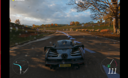

In [32]:
im = Image.open(images[104])
im.to_thumb(128,128)

In [34]:
path_data = Path('./data/images')

In [44]:
race = DataBlock(blocks=(ImageBlock, RegressionBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(valid_pct=0.2, seed=12))

In [46]:
dls = ImageDataLoaders.from_df(df_final, path_data, folder ='./', cols="img_path", num_workers = 0)

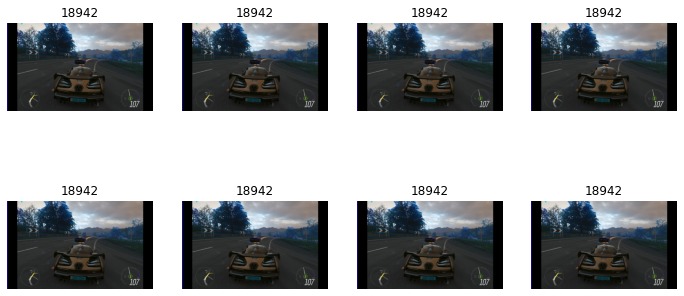

In [47]:
dls.train.show_batch(max_n=8,nrows=2,unique=True)

In [55]:
model = RaceModel()

In [62]:
def mymodel():
    layers = list(fastai.vision.models.resnet34(pretrained=True))[:-2]
    layers += [AdaptiveConcatPool2d(), Flatten()]
    layers += [nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
    layers += [nn.Dropout(p=0.50)]
    layers += [nn.Linear(1024, 512, bias=True), nn.ReLU(inplace=True)]
    layers += [nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
    layers += [nn.Dropout(p=0.50)]
    layers += [nn.Linear(512, 16, bias=True), nn.ReLU(inplace=True)]
    layers += [nn.Linear(16,2)]
    racemodel = nn.Sequential(*layers)
    return racemodel
    

In [64]:
learn = cnn_learner(dls, mymodel, metrics=accuracy)

TypeError: mymodel() got an unexpected keyword argument 'pretrained'

In [ ]:
 learn = Learner(data_wiki_small, RaceModel, model_dir = "/temp/model/", opt_func=opt_func, bn_wd=False, metrics=root_mean_squared_error,
                callback_fns=[ShowGraph]).mixup(stack_y=False, alpha=0.2)